# Clustering Beijing Apartments/Houses 

## Table of contents
* [Introduction](#Introduction)
* [Data](#Data)
  * [Data Explaination](#explaination)
  * [Data Acquisition](#acquisition)
  * [Amap Api](#apis)
  * [Data Cleaning](#cleaning)
* [Analyztion](#Analyztion)
  * [Beijing Map](#beijing_map)
  * [Beijing Houses Distribution](#beijing_houses_distribution)
  * [Normalize Data](#normalize_data)
  * [Apply KMeans](#K_means)
  * [Cluster Houses](#cluster_houses)
- [Conclusion](#Conclusion)

## Introduction

In this project. I will choose Beijing to study. Beijing, as one of the metro-city in the world, there are over 21 million people lived in here. Beijing has 16 distincts and over 6336 square miles, however, there are 21.54 million people lived in this city. Since 2008, China's houses price is increasing continously, until today, the average house price in beijing has tripled. Considering of average salary of chinese, buying a houses could put you in debt for life. For this reason, this project will analyze Beijing's houses to find out different classes houses.

## Data

In order to find the most suitable houses for different type of people, we neeed to collect house data through authoritative website. In this project, I will use web spider to crawl from ***LianJia***(https://bj.lianjia.com/) which is a house trading platform in China. 

### Data Explaination<a id="explaination"></a>
Except the houses' price and areas, there are lots of other features that affect people to choice the hosue or not. As metioned before, Beijing is way too big, so the distance between house and the city center will be one of the major factors. Beside the distance, public transportation capacity afftect the traffic circumstance directly, so we also need to check if there is a subway station near the house or not. In the other hand, for most chinese family, they attach importance to the education of next generation extremely, so we have enough evidence to say that school-nearby houses has higher value in both living and investing aspects. At last, but not the least, Beijing's medical level is the top of China, more medical facilities around houses means better treatment condition in any kind of disease .

In our project, we consider following features as the most critical parts while people buying a home. 
- House's Price
- House's Area
- Distance to the city center(TianAnMen Square)
- Hospital numbers within 1000 meters
- School numbers within 1000 meters
- Subyway numbers within 1000 meters
- New or second-hand houses

### Data Acquisition<a id="acquisition"></a>


To collect house data, we need to use web spider to crawl from LianJia's website. from the website we will be able to download houses' name, price and areas. After that we need to use Amap APIs to collect houses' latitude and longitude, distance to the city center, and other pois.

#### import modules for crawling

In [1]:
import requests
from fake_useragent import UserAgent
from pyquery import PyQuery as pq
import numpy as np
import pandas as pd
import re, json
from tqdm import tqdm

we use fake_useragent library to generate a random user agent for requests method. We will donwload new houses data from Lianjia. The base url is https://bj.fang.lianjia.com/loupan/, each webpage contain 10 new houses information, we will add the '/pgi/' where i is the page number, at the end of base url. By download the data on each page through this function, we will be able to collect all new house data. We will also initialize the data frame to store the house data. Then, we use the pyquery library, which is a jQuery-like library for querying xml documents, analyzing the downloaded html files, and extracting the house information we want from them.

In [2]:
ua = UserAgent(verify_ssl=False)
headers = {'User-Agent':ua.random}
url = "https://bj.fang.lianjia.com/loupan/"

# house_data_list = []
HouseDF = pd.DataFrame(columns=["name","price","unit","areas","distinct","address","type"])

#### New houses crawler

For new homes, the information we can get includes the name, price, area, address of the home and the district to which it belongs. Home prices may be in different units, or they may be average or total prices. To ensure that all data is in the same format, I wrote 4 functions to change all home prices to the same unit and download them:

- **get_onepage_houses**: the page crawler, which can download houses' data of one webpage(10 houses detail data in each page).
- **get_pages**: a loop function that use get_onepage_houses to download all pages.
- **extrect_HousesArea**: since new houses usually has different house type which result differnt size. This function will extract all size.
- **find_lowestArea**:  The price of some homes is marked as the total price, and after browsing the website, I found that the total price corresponds to the minimum house size. Therefore, this feature is to obtain the minimum area of a house.

In [3]:
# make two functions for extract NewHouseArea range and the lowestArea
def extract_HouseArea(houseArea):
    pattern = re.compile("[0-9]+")
    areas = re.findall(pattern,houseArea)
    return areas

def find_lowestArea(areaList):    
    if areaList != []:
        return areaList[0]
    else:
        return "tbd"

In [4]:
# get one page houses details
house_data_list = [] #list for each page houses' data in type of dataframe
def get_onepage_house(url):
    r = requests.get(url, timeout =10, headers = headers)
    if r.status_code == 200:
        r.encoding = r.apparent_encoding
        doc = pq(r.text)
        one_house = {}
        list_houses = doc("ul.resblock-list-wrapper > li > div")
        for house in list_houses.items():
            item = pq(house.html())
            name = item("div.resblock-name > a")
            unit = item("div.resblock-price > div.main-price > span.desc")
            tempArea = item("div > div.resblock-area > span").text()
            areaList = extract_HouseArea(tempArea)
            areaStr = ",".join(areaList)
            lowestArea = find_lowestArea(areaList)
            tempPrice = item("div.resblock-price > div.main-price > span.number").text()
            if "总价" in unit.text() and (lowestArea !='tbd'):
                price = float(tempPrice)*10000/float(lowestArea)
            else:
                price = tempPrice
            distinct = item("div.resblock-location > span:nth-child(1)")
            address = item("div.resblock-location > a")
            ifNewHouse = 1
            houseData = {"name":name.text(),"price":price,"unit":"RMB/㎡","areas":areaStr,"distinct":distinct.text(),"address":address.text(),"type":ifNewHouse}
            oneHouseDF = pd.DataFrame(houseData,columns=["name","price","unit","areas","distinct","address","type"],index=[0])
            # one webpage house data make a dataframe, and then all dataframe will be append to a list of dataframe which including all houses' data. In the end we will use pd.concat method to construct a Large DataFrame for new houses.
            house_data_list.append(oneHouseDF)

        
# loop function
def get_pages(baseUrl, pages):
    pbar = tqdm(total=100)
    for i in range(1,pages):
        pbar.update((1/(pages-1))*100)
        urlend = "pg" + str(i) + "/"
        compUrl = baseUrl +urlend
        get_onepage_house(compUrl)
    pbar.close()
    newHouseDF = pd.concat(house_data_list,ignore_index=True)
    return newHouseDF

In [5]:
rawNewHousesDF = get_pages(url,19)
# rawNewHousesDF.to_csv('rawNewHousesDF.csv',index=False)
rawNewHousesDF.head()

100.00000000000001it [00:38,  2.60it/s]                                                                                


,name,price,unit,areas,distinct,address,type
0,天恒水岸壹号,54347.8,RMB/㎡,"184,198",房山,良乡大学城西站地铁南侧400米，刺猬河旁,1
1,观唐云鼎,28235.3,RMB/㎡,170,密云,密溪路39号院,1
2,尚峯壹號,36000,RMB/㎡,"107,182",顺义,"中央别墅北区京承高速11号出口, 天承环路8号院",1
3,运河铭著,46000,RMB/㎡,"100,140",通州,商通大道与榆东一街交叉口，温榆河森林公园东500米,1
4,万年广阳郡九号,48500,RMB/㎡,"139,166",房山,长阳清苑南街与汇商东路交汇处西北角,1


In [6]:
print('There are %s new houses data downloaded' %str(rawNewHousesDF.shape[0]))

There are 176 new houses data downloaded


#### Second-hand houses crawler

For second-hand homes, we can get the same data as new homes. The difference is that the price of second-hand housing is displayed as the average price, we do not need the price conversion function. However, we still have to use regular expressions to extract the size of the house. At the same time, different homeowners in the same community can sell their homes at different prices. We also need a function to calculate the average price of a community. Therefore, for second-hand housing, we have 4 functions in total:

- **extract_shHousesArea**: using regex to filter out non numeric characters of houses' areas.
- **get_secondhand_page_houses**: the page crawler, which can download house data of one webpage(30 houses detail data in each page) 
- **get_pages_secondHand**: a loop function that use get_secondhand_page_houses to download all pages.
- **combineSameHouseName**: calculate the average price of one community.

In [7]:
# extract second-hand houses Areas
def extract_shHousesArea(houseDetail):
    pattern = re.compile('[\d+\.]+平米')
    tempArea = re.findall(pattern, houseDetail)
    areaList = "".join(tempArea)
    area = areaList.replace("平米","")
    return area

In [8]:
# Second-Hand Houses MainFunction
secondHandHouseList = []
def get_secondhand_page_houses(url):
    r = requests.get(url, timeout =10, headers = headers)
    if r.status_code == 200:
        r.encoding = r.apparent_encoding
        doc = pq(r.text)
        one_house = {}
        pricePattern = re.compile('[0-9]+')
        list_houses = doc("#content > div.leftContent > ul > li")
        for house in list_houses.items():
            item = pq(house.html())
            name = item("div.info.clear > div.flood > div > a:nth-child(2)")
            preprice = item("div.info.clear > div.priceInfo > div.unitPrice > span")
            priceExtract = re.findall(pricePattern,preprice.text())
            if len(priceExtract) != 0:
                price = priceExtract[0]
            else:
                price = "empty"
            houseDetail = item("div.info.clear > div.address > div").text()
            area = extract_shHousesArea(houseDetail)
            unit = "RMB/m²"
            distinct = "tbd"
            address = "tbd"
            ifNewHouse = 0
            houseData = {"name":name.text(),"price":price,"unit":unit,"areas":area,"distinct":distinct,"address":address,"type":ifNewHouse}
            oneHouseDF = pd.DataFrame(houseData,columns=["name","price","unit","areas","distinct","address","type"],index=[0])
            secondHandHouseList.append(oneHouseDF)


In [9]:
secondHandUrl="https://bj.lianjia.com/ershoufang/"
def get_pages_secondHand(baseUrl, pages):
    pbar = tqdm(total=100)
    for i in range(1,pages):
        urlend = "pg" + str(i) + "/"
        compUrl = baseUrl +urlend
#         print('%s hosues data has downloaded' %str(len(secondHandHouseList)))
        get_secondhand_page_houses(compUrl)
        pbar.update((1/(pages-1))*100)
    pbar.close()
    SHHouseDF = pd.concat(secondHandHouseList,ignore_index=True)
    return SHHouseDF

second-hand cralwer start 

In [10]:
unsortedSecondhandDF = get_pages_secondHand(secondHandUrl, 101)

100%|██████████████████████████████████████████████████████████████████████████████| 100.0/100 [02:31<00:00,  1.52s/it]


In [11]:
def combineSameHouseName(dfName):
    dfName = dfName[dfName['price'] != 'empty'].copy()
    dfName[['price']] = dfName[['price']].astype(float).copy()
    pricePart = dfName.groupby(dfName['name'])['price'].mean().reset_index().copy()
    commonPart = dfName.drop_duplicates('name')
    commonPart.drop('price',axis=1,inplace=True)
    combinedDF = pd.merge(pricePart,commonPart,on='name',how='outer')
    return combinedDF

In [12]:
rawSecondhandHousedsDF = combineSameHouseName(unsortedSecondhandDF)
# rawSecondhandHousedsDF.to_csv('rawSecondhandHousedsDF.csv')

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
rawSecondhandHousedsDF

,name,price,unit,areas,distinct,address,type
0,10AM新坐标,65492.0,RMB/m²,32.28,tbd,tbd,0
1,8哩岛,44455.0,RMB/m²,140.21,tbd,tbd,0
2,BOBO自由城,53524.5,RMB/m²,102.48,tbd,tbd,0
3,CBD传奇,71839.0,RMB/m²,65.95,tbd,tbd,0
4,CBD总部公寓二期,88126.0,RMB/m²,99.29,tbd,tbd,0
...,...,...,...,...,...,...,...
1719,龙锦苑东一区,37905.0,RMB/m²,124.02,tbd,tbd,0
1720,龙锦苑东二区,32922.0,RMB/m²,118.88,tbd,tbd,0
1721,龙锦苑东五区,35935.5,RMB/m²,99.68,tbd,tbd,0
1722,龙锦苑二区,44304.0,RMB/m²,88.48,tbd,tbd,0


In [14]:
print('There are %s second-hand houses data downloaded' %str(rawSecondhandHousedsDF.shape[0]))

There are 1724 second-hand houses data downloaded


### Amap Api<a id="apis"></a>

Amap is one of the top three map service companies in China, providing high-quality Web APIs for positioning, poi, and more. In this section, we need to use three APIs to collect basic data, such as the distance to the city center, latitude and longitude, and the number of hospitals, schools, and subway stations less than 1,000 meters from the house.

In [15]:
#setting up locaiton data baseApi, type equal to 120000 which means result will only show hosues.
locationBaseApi = "https://restapi.amap.com/v3/place/text?key=59d76f9270ae6222f20be27206322c48&keywords={keywords}&types=120000&city=北京&children=0&offset=20&page=1&extensions=all"
def amap_poi_func(keywords):
    makedApi = locationBaseApi.format(keywords=keywords)
    response = requests.get(makedApi).json()
    return response

def add_locaiton_data(DfName,DfRowIndex,poidata):
    if poidata['pois'] != []:
        location = poidata['pois'][0]['location'].split(',',1)
        latitude = location[1]
        longitude = location[0]
        distinct = poidata['pois'][0]['adname']
        if poidata['pois'][0]['address'] != []:
            address = poidata['pois'][0]['address']
        else:
            address = "tbd"
        DfName.loc[DfRowIndex,'distinct'] = distinct
        DfName.loc[DfRowIndex,'address'] = address
        DfName.loc[DfRowIndex,'latitude'] = latitude
        DfName.loc[DfRowIndex,'longitude'] = longitude

def completeDFLocation(DfName,startrow,endrow):
    pbar = tqdm(total=100)
    for i in range(startrow,endrow):
        keywords = DfName.loc[i,'name']
        locationJson = amap_poi_func(keywords)
        add_locaiton_data(DfName,i,locationJson)
        pbar.update((1/(endrow-startrow))*100)
    pbar.close()

get new and second-hand houses location data

In [16]:
completeDFLocation(rawNewHousesDF,0,len(rawNewHousesDF))
print('%d new houses location data downloaded' %rawNewHousesDF.size)
completeDFLocation(rawSecondhandHousedsDF,0,len(rawSecondhandHousedsDF))
print('%d second-hand houses location data downloaded' %rawSecondhandHousedsDF.size)

100%|█████████████████████████████████████████████████████████████████▉| 99.99999999999974/100 [00:44<00:00,  2.24it/s]


1584 new houses location data downloaded


100%|█████████████████████████████████████████████████████████████████▉| 99.99999999999638/100 [07:15<00:00,  4.35s/it]


15516 second-hand houses location data downloaded


#### Comibne New and Second-hand houses dataframe.

In [17]:
rawCombineDF = pd.concat([rawNewHousesDF,rawSecondhandHousedsDF],axis=0,sort=False)
rawCombineDF.reset_index(drop=True,inplace=True)
# rawCombineDF.to_csv("rawCombineDF.csv",index=False)
rawCombineDF

,name,price,unit,areas,distinct,address,type,latitude,longitude
0,天恒水岸壹号,54347.8,RMB/㎡,"184,198",房山区,揽秀南大街与良乡东街交叉口,1,39.714265,116.155789
1,观唐云鼎,28235.3,RMB/㎡,170,密云区,密关路与701乡道交叉口西北100米,1,40.427632,116.831226
2,尚峯壹號,36000,RMB/㎡,"107,182",顺义区,京承温榆河高端低密生活区京承高速11出口处,1,40.213458,116.51018
3,运河铭著,46000,RMB/㎡,"100,140",通州区,永顺镇商通大道与榆东一街交口,1,39.951533,116.652210
4,万年广阳郡九号,48500,RMB/㎡,"139,166",房山区,汇商东路,1,39.719431,116.193375
...,...,...,...,...,...,...,...,...,...
1895,龙锦苑东一区,37905,RMB/m²,124.02,昌平区,黄平路,0,40.08904,116.368151
1896,龙锦苑东二区,32922,RMB/m²,118.88,昌平区,龙锦苑东2区,0,40.08602,116.368381
1897,龙锦苑东五区,35935.5,RMB/m²,99.68,昌平区,回龙观龙锦三街,0,40.086315,116.37421
1898,龙锦苑二区,44304,RMB/m²,88.48,昌平区,昌平回龙观龙锦苑二区,0,40.088405,116.355917


In [18]:
#rawCombineDF.to_csv("rawCombineDF.csv",index=False)

#### Use AmpApi to get poi data including numbers of subway station, hospital, schools

In [19]:
def getAroundDetails(location):
    #key = 59d76f9270ae6222f20be27206322c48
    #包含学校：高等院校141201，中学141202，小学141203，幼儿园141204、医院：三级甲等医院090101，专科医院090200、地铁站150500、商场060100
    #poitype=''
    baseApi = 'https://restapi.amap.com/v3/place/around?key=59d76f9270ae6222f20be27206322c48&location={location}&keywords=&types=141201|141202|141203|141204|090101|090200|150500|060100&radius=1000&offset=20&page=1&extensions=all'
    compeltedApi = baseApi.format(location = location)
    response = requests.get(compeltedApi).json()
    return response

def AddAroundDetail(poijson,DFname,DFrowIndex):
    schoolNumber = 0
    schoolList = []
    subwayNumber = 0
    subwayList = []
    hospitalNumber = 0
    hospitalList = []
    if 'pois' in poijson.keys():
        for position in poijson['pois']:
            if "学校" in position['type']:
                schoolNumber += 1
                schoolList.append(position['name'])
            if "地铁" in position['type']:
                subwayNumber += 1
                subwayList.append(position['name'])
            if "医院" in position['type']:
                hospitalNumber += 1
                hospitalList.append(position['name'])
    DFname.loc[DFrowIndex,'schoolNumber'] = schoolNumber
    DFname.loc[DFrowIndex,'schoolList'] = ','.join(schoolList)
    DFname.loc[DFrowIndex,'subwayNumber'] = subwayNumber
    DFname.loc[DFrowIndex,'subwayList'] = ','.join(subwayList)
    DFname.loc[DFrowIndex,'hospitalNumber'] = hospitalNumber
    DFname.loc[DFrowIndex,'hospitalList'] = ','.join(hospitalList)

def Loop_AroundDetail(DFName,startRow,EndRow):
    pbar = tqdm(total=100)
    for i in range(startRow,EndRow):
        locationdata = str(DFName.loc[i,'longitude']) + ',' + str(DFName.loc[i,'latitude'])
        poijson = getAroundDetails(locationdata)
        AddAroundDetail(poijson,DFName,i)
        pbar.update((1 / (EndRow - 1)) * 100)
    pbar.close()
        

In [20]:
Loop_AroundDetail(rawCombineDF,0,len(rawCombineDF))


100.05265929436445it [08:23,  5.03s/it]                                                                                


The data look like

In [21]:
rawCombineDF

,name,price,unit,areas,distinct,address,type,latitude,longitude,schoolNumber,schoolList,subwayNumber,subwayList,hospitalNumber,hospitalList
0,天恒水岸壹号,54347.8,RMB/㎡,"184,198",房山区,揽秀南大街与良乡东街交叉口,1,39.714265,116.155789,6.0,"良乡四小滨河校区,爱童语艺教园成长中心,北京工商大学良乡校区(西区),北京市房山区智慧双语艺...",1.0,良乡大学城西(地铁站),3.0,"皓齿佳口腔,阿尔博尼(北京)口腔医院,鹏园医院"
1,观唐云鼎,28235.3,RMB/㎡,170,密云区,密关路与701乡道交叉口西北100米,1,40.427632,116.831226,1.0,密云区东智小学,0.0,,0.0,
2,尚峯壹號,36000,RMB/㎡,"107,182",顺义区,京承温榆河高端低密生活区京承高速11出口处,1,40.213458,116.51018,1.0,北京教科院附属顺义小学(建设中),0.0,,0.0,
3,运河铭著,46000,RMB/㎡,"100,140",通州区,永顺镇商通大道与榆东一街交口,1,39.951533,116.652210,1.0,玉博睿金地幼儿园,0.0,,0.0,
4,万年广阳郡九号,48500,RMB/㎡,"139,166",房山区,汇商东路,1,39.719431,116.193375,0.0,,0.0,,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,龙锦苑东一区,37905,RMB/m²,124.02,昌平区,黄平路,0,40.08904,116.368151,9.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,金奥幼儿园,金奥经典艺术幼儿园,北京市昌平区幸福童乐...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,诚之康口腔·种植牙中心龙锦分院..."
1896,龙锦苑东二区,32922,RMB/m²,118.88,昌平区,龙锦苑东2区,0,40.08602,116.368381,10.0,"天一宝贝双语艺术幼儿园,快乐宝贝幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,景尚口腔,诚之康口腔·种植牙中..."
1897,龙锦苑东五区,35935.5,RMB/m²,99.68,昌平区,回龙观龙锦三街,0,40.086315,116.37421,8.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",0.0,,7.0,"诚之康口腔·种植牙中心龙锦分院,怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所..."
1898,龙锦苑二区,44304,RMB/m²,88.48,昌平区,昌平回龙观龙锦苑二区,0,40.088405,116.355917,10.0,"首都师范大学附属回龙观育新学校,梦的花园双语艺术幼儿园,梦的花园(龙锦三街),京师蓝天双语艺...",2.0,"平西府(地铁站),回龙观东大街地铁站A西北口",7.0,"北京睿养中医医院,睿养齿科牙齿美学中心,和信口腔,瑞吉纳口腔(龙康口腔),北京京都儿童医院,..."


#### Use AmpApi to get the distance between houses and the city center

We choose the simpleast way to measure the distance between houses and the city center, the straight-line distance which evaluate by meters.

In [22]:
def distance_functiuon(originLocation):
    #key = 59d76f9270ae6222f20be27206322c48
    #destLocation天安门:116.397477,39.908692
    baseApi = 'https://restapi.amap.com/v3/distance?key=59d76f9270ae6222f20be27206322c48&origins={originLocation}&destination=116.397477,39.908692&type=0'
#     print(baseApi)
    completedApi = baseApi.format(originLocation=originLocation)
    response = requests.get(completedApi).json()
    return response

def extract_distance(distanceJson,DFName,DFRow):
    if 'results' in distanceJson.keys():
        distance = distanceJson['results'][0]['distance']
        DFName.loc[DFRow,'distance'] = distance
    
def loop_distance(DFName,startRow,EndRow):
    pbar = tqdm(total=100)
    for i in range(startRow,EndRow):
        distancedata = str(DFName.loc[i,'longitude']) + ',' + str(DFName.loc[i,'latitude'])
        distanceJson = distance_functiuon(distancedata)
        extract_distance(distanceJson,DFName,i)
        pbar.update((1 / (EndRow - 1)) * 100)
    pbar.close()

In [23]:
loop_distance(rawCombineDF,0,len(rawCombineDF))

100.05265929436445it [05:55,  3.56s/it]                                                                                


After getting distance data

In [24]:
rawCombineDF

,name,price,unit,areas,distinct,address,type,latitude,longitude,schoolNumber,schoolList,subwayNumber,subwayList,hospitalNumber,hospitalList,distance
0,天恒水岸壹号,54347.8,RMB/㎡,"184,198",房山区,揽秀南大街与良乡东街交叉口,1,39.714265,116.155789,6.0,"良乡四小滨河校区,爱童语艺教园成长中心,北京工商大学良乡校区(西区),北京市房山区智慧双语艺...",1.0,良乡大学城西(地铁站),3.0,"皓齿佳口腔,阿尔博尼(北京)口腔医院,鹏园医院",29925
1,观唐云鼎,28235.3,RMB/㎡,170,密云区,密关路与701乡道交叉口西北100米,1,40.427632,116.831226,1.0,密云区东智小学,0.0,,0.0,,68545
2,尚峯壹號,36000,RMB/㎡,"107,182",顺义区,京承温榆河高端低密生活区京承高速11出口处,1,40.213458,116.51018,1.0,北京教科院附属顺义小学(建设中),0.0,,0.0,,35259
3,运河铭著,46000,RMB/㎡,"100,140",通州区,永顺镇商通大道与榆东一街交口,1,39.951533,116.652210,1.0,玉博睿金地幼儿园,0.0,,0.0,,22261
4,万年广阳郡九号,48500,RMB/㎡,"139,166",房山区,汇商东路,1,39.719431,116.193375,0.0,,0.0,,0.0,,27357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,龙锦苑东一区,37905,RMB/m²,124.02,昌平区,黄平路,0,40.08904,116.368151,9.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,金奥幼儿园,金奥经典艺术幼儿园,北京市昌平区幸福童乐...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,诚之康口腔·种植牙中心龙锦分院...",20231
1896,龙锦苑东二区,32922,RMB/m²,118.88,昌平区,龙锦苑东2区,0,40.08602,116.368381,10.0,"天一宝贝双语艺术幼儿园,快乐宝贝幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,景尚口腔,诚之康口腔·种植牙中...",19895
1897,龙锦苑东五区,35935.5,RMB/m²,99.68,昌平区,回龙观龙锦三街,0,40.086315,116.37421,8.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",0.0,,7.0,"诚之康口腔·种植牙中心龙锦分院,怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所...",19872
1898,龙锦苑二区,44304,RMB/m²,88.48,昌平区,昌平回龙观龙锦苑二区,0,40.088405,116.355917,10.0,"首都师范大学附属回龙观育新学校,梦的花园双语艺术幼儿园,梦的花园(龙锦三街),京师蓝天双语艺...",2.0,"平西府(地铁站),回龙观东大街地铁站A西北口",7.0,"北京睿养中医医院,睿养齿科牙齿美学中心,和信口腔,瑞吉纳口腔(龙康口腔),北京京都儿童医院,...",20317


### Data Cleanning<a id="cleaning"></a>
Now we have a dataframe that contain Houses' name, price, unit, areas, distinct, address, hosue type, latitude and longitude. However, some data are missing and some data are not a number, let's clean these data.

#### First, we drop those data with price are undetermined, in chinese, it is '价格待定'. 

In [25]:
rawCombineDF = rawCombineDF[rawCombineDF['price'] != '价格待定'].copy()
rawCombineDF['price'] = rawCombineDF['price'].replace(['价格待定'],[''])

In [26]:
rawCombineDF

,name,price,unit,areas,distinct,address,type,latitude,longitude,schoolNumber,schoolList,subwayNumber,subwayList,hospitalNumber,hospitalList,distance
0,天恒水岸壹号,54347.8,RMB/㎡,"184,198",房山区,揽秀南大街与良乡东街交叉口,1,39.714265,116.155789,6.0,"良乡四小滨河校区,爱童语艺教园成长中心,北京工商大学良乡校区(西区),北京市房山区智慧双语艺...",1.0,良乡大学城西(地铁站),3.0,"皓齿佳口腔,阿尔博尼(北京)口腔医院,鹏园医院",29925
1,观唐云鼎,28235.3,RMB/㎡,170,密云区,密关路与701乡道交叉口西北100米,1,40.427632,116.831226,1.0,密云区东智小学,0.0,,0.0,,68545
2,尚峯壹號,36000,RMB/㎡,"107,182",顺义区,京承温榆河高端低密生活区京承高速11出口处,1,40.213458,116.51018,1.0,北京教科院附属顺义小学(建设中),0.0,,0.0,,35259
3,运河铭著,46000,RMB/㎡,"100,140",通州区,永顺镇商通大道与榆东一街交口,1,39.951533,116.652210,1.0,玉博睿金地幼儿园,0.0,,0.0,,22261
4,万年广阳郡九号,48500,RMB/㎡,"139,166",房山区,汇商东路,1,39.719431,116.193375,0.0,,0.0,,0.0,,27357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,龙锦苑东一区,37905,RMB/m²,124.02,昌平区,黄平路,0,40.08904,116.368151,9.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,金奥幼儿园,金奥经典艺术幼儿园,北京市昌平区幸福童乐...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,诚之康口腔·种植牙中心龙锦分院...",20231
1896,龙锦苑东二区,32922,RMB/m²,118.88,昌平区,龙锦苑东2区,0,40.08602,116.368381,10.0,"天一宝贝双语艺术幼儿园,快乐宝贝幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,景尚口腔,诚之康口腔·种植牙中...",19895
1897,龙锦苑东五区,35935.5,RMB/m²,99.68,昌平区,回龙观龙锦三街,0,40.086315,116.37421,8.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",0.0,,7.0,"诚之康口腔·种植牙中心龙锦分院,怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所...",19872
1898,龙锦苑二区,44304,RMB/m²,88.48,昌平区,昌平回龙观龙锦苑二区,0,40.088405,116.355917,10.0,"首都师范大学附属回龙观育新学校,梦的花园双语艺术幼儿园,梦的花园(龙锦三街),京师蓝天双语艺...",2.0,"平西府(地铁站),回龙观东大街地铁站A西北口",7.0,"北京睿养中医医院,睿养齿科牙齿美学中心,和信口腔,瑞吉纳口腔(龙康口腔),北京京都儿童医院,...",20317


### Secondly, we only remain house's highest price.

In [27]:
def drop_lowestPrice(rawDF):
    rawDF[['price']] = rawDF[['price']].copy().astype(float)
    priceDF = rawDF.groupby(rawDF['name'])['price'].max().reset_index()
    commonDF = rawDF.drop_duplicates("name") #get other common columns
    commonDF.drop('price',axis=1,inplace=True)
    completedDF = pd.merge(priceDF,commonDF,on='name',how='outer')
    return completedDF

In [39]:
CombineDF = drop_lowestPrice(rawCombineDF)
CombineDF

,name,price,unit,areas,distinct,address,type,latitude,longitude,schoolNumber,schoolList,subwayNumber,subwayList,hospitalNumber,hospitalList,distance
0,10AM新坐标,65492.0,RMB/m²,32.28,朝阳区,方庄东路,0,39.868745,116.443373,10.0,"光明幼儿园朝阳分园,北京市东城区光明幼儿园周转园,红门市委幼儿园,红黄蓝方庄国际幼儿园,北京...",1.0,方庄(地铁站),9.0,"北京高新医院-高新医院口腔科,中医肿瘤名医工作室,北京劲松口腔医院,体坛中医口腔,中国医学科...",5928
1,8哩岛,44455.0,RMB/m²,140.21,通州区,榆纪路,0,39.936657,116.641781,3.0,"8哩岛幼儿园,北京物资学院,台湾金雅国际幼儿园",0.0,,0.0,,21087
2,BOBO自由城,53524.5,RMB/m²,102.48,通州区,东果园65号,0,39.908828,116.693801,8.0,"水米田幼儿园(自由城园区),北京·通州·芙蓉小学,北京市通州区芙蓉幼儿园,通州区教工幼儿园,...",1.0,北运河西(地铁站),3.0,"北京德泽口腔医院,北京京通医院-京通整形·口腔,北京京通医院-京通整形",25302
3,CBD传奇,71839.0,RMB/m²,65.95,朝阳区,西大望路西侧63号院(CBD传奇),0,39.887624,116.477012,6.0,"北京市陈经纶中学帝景校区,北京市朝阳区淘乐思幼儿园,北京工业大学附属中学(首城国际校区),妙...",1.0,平乐园(地铁站),12.0,"北京朝阳区整形美容医院,朗皓齿科,冠美口腔平乐总院,科尔口腔(西大望路),艺佳美医疗美容,佳...",7185
4,CBD总部公寓二期,88126.0,RMB/m²,99.29,朝阳区,东三环国贸桥西南角,0,39.899629,116.454618,9.0,"宝蓓心儿童成长中心,芳草地国际学校双花园校区,小天使幼儿园(天力街),创艺宝贝早教中心(富力...",0.0,,11.0,"格芮丝美容美体会所,慕美人国际医疗美容,京浩口腔,唯颜医疗美容,京浩口腔门诊,合生齿科,凯润...",4982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,龙锦苑东一区,37905.0,RMB/m²,124.02,昌平区,黄平路,0,40.08904,116.368151,9.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,金奥幼儿园,金奥经典艺术幼儿园,北京市昌平区幸福童乐...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,诚之康口腔·种植牙中心龙锦分院...",20231
1865,龙锦苑东二区,32922.0,RMB/m²,118.88,昌平区,龙锦苑东2区,0,40.08602,116.368381,10.0,"天一宝贝双语艺术幼儿园,快乐宝贝幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,景尚口腔,诚之康口腔·种植牙中...",19895
1866,龙锦苑东五区,35935.5,RMB/m²,99.68,昌平区,回龙观龙锦三街,0,40.086315,116.37421,8.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",0.0,,7.0,"诚之康口腔·种植牙中心龙锦分院,怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所...",19872
1867,龙锦苑二区,44304.0,RMB/m²,88.48,昌平区,昌平回龙观龙锦苑二区,0,40.088405,116.355917,10.0,"首都师范大学附属回龙观育新学校,梦的花园双语艺术幼儿园,梦的花园(龙锦三街),京师蓝天双语艺...",2.0,"平西府(地铁站),回龙观东大街地铁站A西北口",7.0,"北京睿养中医医院,睿养齿科牙齿美学中心,和信口腔,瑞吉纳口腔(龙康口腔),北京京都儿童医院,...",20317


### Thirdly, areas column may contains two areas or empty, we only keep the largest one and delete empty row.

In [40]:
for i in range(1, len(CombineDF['areas'])):
    if (type(CombineDF.loc[i,'areas']) is str) and ',' in CombineDF.loc[i,'areas']:
        CombineDF.loc[i,'areas'] = max(map(float,CombineDF.loc[i,'areas'].split(',')))

In [41]:
CombineDF = CombineDF[CombineDF['areas'] != ''].copy().reset_index(drop=True)

In [42]:
CombineDF

,name,price,unit,areas,distinct,address,type,latitude,longitude,schoolNumber,schoolList,subwayNumber,subwayList,hospitalNumber,hospitalList,distance
0,10AM新坐标,65492.0,RMB/m²,32.28,朝阳区,方庄东路,0,39.868745,116.443373,10.0,"光明幼儿园朝阳分园,北京市东城区光明幼儿园周转园,红门市委幼儿园,红黄蓝方庄国际幼儿园,北京...",1.0,方庄(地铁站),9.0,"北京高新医院-高新医院口腔科,中医肿瘤名医工作室,北京劲松口腔医院,体坛中医口腔,中国医学科...",5928
1,8哩岛,44455.0,RMB/m²,140.21,通州区,榆纪路,0,39.936657,116.641781,3.0,"8哩岛幼儿园,北京物资学院,台湾金雅国际幼儿园",0.0,,0.0,,21087
2,BOBO自由城,53524.5,RMB/m²,102.48,通州区,东果园65号,0,39.908828,116.693801,8.0,"水米田幼儿园(自由城园区),北京·通州·芙蓉小学,北京市通州区芙蓉幼儿园,通州区教工幼儿园,...",1.0,北运河西(地铁站),3.0,"北京德泽口腔医院,北京京通医院-京通整形·口腔,北京京通医院-京通整形",25302
3,CBD传奇,71839.0,RMB/m²,65.95,朝阳区,西大望路西侧63号院(CBD传奇),0,39.887624,116.477012,6.0,"北京市陈经纶中学帝景校区,北京市朝阳区淘乐思幼儿园,北京工业大学附属中学(首城国际校区),妙...",1.0,平乐园(地铁站),12.0,"北京朝阳区整形美容医院,朗皓齿科,冠美口腔平乐总院,科尔口腔(西大望路),艺佳美医疗美容,佳...",7185
4,CBD总部公寓二期,88126.0,RMB/m²,99.29,朝阳区,东三环国贸桥西南角,0,39.899629,116.454618,9.0,"宝蓓心儿童成长中心,芳草地国际学校双花园校区,小天使幼儿园(天力街),创艺宝贝早教中心(富力...",0.0,,11.0,"格芮丝美容美体会所,慕美人国际医疗美容,京浩口腔,唯颜医疗美容,京浩口腔门诊,合生齿科,凯润...",4982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,龙锦苑东一区,37905.0,RMB/m²,124.02,昌平区,黄平路,0,40.08904,116.368151,9.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,金奥幼儿园,金奥经典艺术幼儿园,北京市昌平区幸福童乐...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,诚之康口腔·种植牙中心龙锦分院...",20231
1855,龙锦苑东二区,32922.0,RMB/m²,118.88,昌平区,龙锦苑东2区,0,40.08602,116.368381,10.0,"天一宝贝双语艺术幼儿园,快乐宝贝幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",1.0,回龙观东大街(地铁站),8.0,"怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所,景尚口腔,诚之康口腔·种植牙中...",19895
1856,龙锦苑东五区,35935.5,RMB/m²,99.68,昌平区,回龙观龙锦三街,0,40.086315,116.37421,8.0,"快乐宝贝幼儿园,天一宝贝双语艺术幼儿园,北京市昌平区幸福童乐幼儿园,幸福童年双语第八幼儿园,...",0.0,,7.0,"诚之康口腔·种植牙中心龙锦分院,怡达齿科,嘉诺口腔,爱齿佳美医院管理有限公司爱齿佳美口腔诊所...",19872
1857,龙锦苑二区,44304.0,RMB/m²,88.48,昌平区,昌平回龙观龙锦苑二区,0,40.088405,116.355917,10.0,"首都师范大学附属回龙观育新学校,梦的花园双语艺术幼儿园,梦的花园(龙锦三街),京师蓝天双语艺...",2.0,"平西府(地铁站),回龙观东大街地铁站A西北口",7.0,"北京睿养中医医院,睿养齿科牙齿美学中心,和信口腔,瑞吉纳口腔(龙康口腔),北京京都儿童医院,...",20317


### Also, Some of the data maybe Nan or the data type is not float which is not suitable for calculation, we will drop non-numeric data and change all columns' data type into float.

In [77]:
CombineDF = CombineDF.dropna().reset_index(drop=True)
CombineDF['areas'] = CombineDF['areas'].astype(np.float)
CombineDF['distance'] = CombineDF['distance'].astype(np.float)

In [79]:
CombineDF.head()

,name,price,unit,areas,distinct,address,type,latitude,longitude,schoolNumber,schoolList,subwayNumber,subwayList,hospitalNumber,hospitalList,distance
0,10AM新坐标,65492.0,RMB/m²,32.28,朝阳区,方庄东路,0,39.868745,116.443373,10.0,"光明幼儿园朝阳分园,北京市东城区光明幼儿园周转园,红门市委幼儿园,红黄蓝方庄国际幼儿园,北京...",1.0,方庄(地铁站),9.0,"北京高新医院-高新医院口腔科,中医肿瘤名医工作室,北京劲松口腔医院,体坛中医口腔,中国医学科...",5928.0
1,8哩岛,44455.0,RMB/m²,140.21,通州区,榆纪路,0,39.936657,116.641781,3.0,"8哩岛幼儿园,北京物资学院,台湾金雅国际幼儿园",0.0,,0.0,,21087.0
2,BOBO自由城,53524.5,RMB/m²,102.48,通州区,东果园65号,0,39.908828,116.693801,8.0,"水米田幼儿园(自由城园区),北京·通州·芙蓉小学,北京市通州区芙蓉幼儿园,通州区教工幼儿园,...",1.0,北运河西(地铁站),3.0,"北京德泽口腔医院,北京京通医院-京通整形·口腔,北京京通医院-京通整形",25302.0
3,CBD传奇,71839.0,RMB/m²,65.95,朝阳区,西大望路西侧63号院(CBD传奇),0,39.887624,116.477012,6.0,"北京市陈经纶中学帝景校区,北京市朝阳区淘乐思幼儿园,北京工业大学附属中学(首城国际校区),妙...",1.0,平乐园(地铁站),12.0,"北京朝阳区整形美容医院,朗皓齿科,冠美口腔平乐总院,科尔口腔(西大望路),艺佳美医疗美容,佳...",7185.0
4,CBD总部公寓二期,88126.0,RMB/m²,99.29,朝阳区,东三环国贸桥西南角,0,39.899629,116.454618,9.0,"宝蓓心儿童成长中心,芳草地国际学校双花园校区,小天使幼儿园(天力街),创艺宝贝早教中心(富力...",0.0,,11.0,"格芮丝美容美体会所,慕美人国际医疗美容,京浩口腔,唯颜医疗美容,京浩口腔门诊,合生齿科,凯润...",4982.0


### In the end, since we only use 7 features, we will drop other columns。

In [82]:
HouseData = CombineDF.drop(['schoolList','subwayList','hospitalList','distinct','address','unit'],axis=1)
HouseData.head()

,name,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
0,10AM新坐标,65492.0,32.28,0,39.868745,116.443373,10.0,1.0,9.0,5928.0
1,8哩岛,44455.0,140.21,0,39.936657,116.641781,3.0,0.0,0.0,21087.0
2,BOBO自由城,53524.5,102.48,0,39.908828,116.693801,8.0,1.0,3.0,25302.0
3,CBD传奇,71839.0,65.95,0,39.887624,116.477012,6.0,1.0,12.0,7185.0
4,CBD总部公寓二期,88126.0,99.29,0,39.899629,116.454618,9.0,0.0,11.0,4982.0


In [83]:
HouseData.to_csv('Hosuedata.csv')

## Analyztion

### Beijing Map<a id="beijing_map"></a>

In [85]:
import folium

In [86]:
BJmap = folium.Map(
    location=[39.90, 116.38],
    title="Beijing Map",
    zoom_start=11)
BJmap

### Beijing Houses Distribution<a id="beijing_houses_distribution"></a>

In [87]:
for log,lat,name,price  in zip(HouseData['longitude'],HouseData['latitude'],HouseData['name'],HouseData['price']):
    detail = name + "," + "Price:" + str(price) +"RMB/㎡"
    folium.vector_layers.CircleMarker(
        [lat, log],
        radius=4,
        tooltip=detail,
        fill=True,
        stroke=False,
#         color='blue',
        fill_color='blue',
        fill_opacity=0.5
    ).add_to(BJmap)
BJmap

### Normalize Data<a id="normalize_data"></a>

Our features are measured by different units, for example, price is measure by RMB and distance are measured by meters. Therefore, we use normalization method to transform all data in to range [0,1].

In [88]:
from sklearn import preprocessing
from sklearn import metrics

In [94]:
AnalyzeDF = HouseData.set_index('name').copy()
AnalyzeDF.head()

,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
name,,,,,,,,,
10AM新坐标,65492.0,32.28,0,39.868745,116.443373,10.0,1.0,9.0,5928.0
8哩岛,44455.0,140.21,0,39.936657,116.641781,3.0,0.0,0.0,21087.0
BOBO自由城,53524.5,102.48,0,39.908828,116.693801,8.0,1.0,3.0,25302.0
CBD传奇,71839.0,65.95,0,39.887624,116.477012,6.0,1.0,12.0,7185.0
CBD总部公寓二期,88126.0,99.29,0,39.899629,116.454618,9.0,0.0,11.0,4982.0


In [95]:
normalizer = preprocessing.Normalizer().fit(AnalyzeDF)
normalizer

Normalizer(copy=True, norm='l2')

In [96]:
normData = normalizer.transform(AnalyzeDF)

In [97]:
normData

array([[9.95926645e-01, 4.90876933e-04, 0.00000000e+00, ...,
        1.52068443e-05, 1.36861598e-04, 9.01461728e-02],
       [9.03500279e-01, 2.84961813e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.28570698e-01],
       [9.04072145e-01, 1.73097018e-03, 0.00000000e+00, ...,
        1.68908097e-05, 5.06724292e-05, 4.27371267e-01],
       ...,
       [8.75101892e-01, 2.42740901e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.70464116e-04, 4.83923274e-01],
       [9.08974897e-01, 1.81532365e-03, 0.00000000e+00, ...,
        4.10335363e-05, 1.43617377e-04, 4.16839179e-01],
       [8.95436232e-01, 2.54132404e-03, 0.00000000e+00, ...,
        2.21215532e-05, 1.54850873e-04, 4.45174137e-01]])

### Apply KMeans <a id="K_means"></a>

In [98]:
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In order to find the best number of clusters, we can iterate with different numbers and find the largest calinski harabasz score. Also, since there are too many 

In [99]:
sc_score_list = {}
SSE = []
def KMeans_Method(num_clusters):
    k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
    k_means.fit(normData)
    labels = k_means.labels_
    sc_score = metrics.silhouette_score(normData,labels,metric='euclidean')
    SSE.append(k_means.inertia_)
    sc_score_list[sc_score] = num_clusters

In [100]:
for num_clusters in range(2,15):
    KMeans_Method(num_clusters)   
print(sc_score_list)

{0.6383764666647985: 2, 0.6205952364173867: 3, 0.5981719555977507: 4, 0.6041977870738173: 5, 0.5709140946253054: 6, 0.543508822473951: 7, 0.5321759828402731: 8, 0.5318421491739262: 9, 0.5316153444112692: 10, 0.5324983045049949: 11, 0.5296814732541648: 12, 0.5303580517412594: 13, 0.5326794874100677: 14}


In [101]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

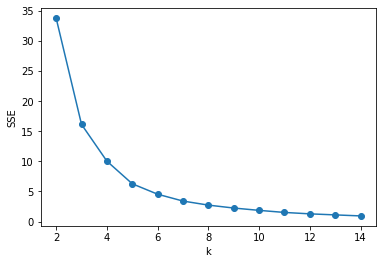

In [102]:
X = range(2,15)
plot.figure()
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.title('elbow method graph')
plt.show

In [103]:
list(sc_score_list.keys())

[0.6383764666647985,
 0.6205952364173867,
 0.5981719555977507,
 0.6041977870738173,
 0.5709140946253054,
 0.543508822473951,
 0.5321759828402731,
 0.5318421491739262,
 0.5316153444112692,
 0.5324983045049949,
 0.5296814732541648,
 0.5303580517412594,
 0.5326794874100677]

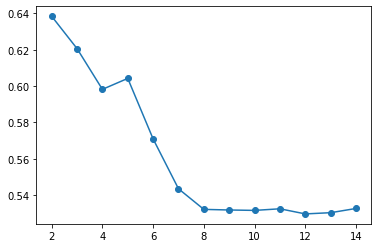

In [104]:
XX = range(2,15)
plt.figure()
plt.xlabel('k')
plt.ylabel('sc_score')
plt.plot(XX, list(sc_score_list.keys()),'o-')
plt.title('sc_score graph')
plt.show()

**as we can see from sc_score and elbow method** According to elbow method, we can see the best cluster number should be four or five. 

In [105]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(normData)
labels = k_means.labels_


In [106]:
AnalyzeDF['Labels'] = labels

In [107]:
AnalyzeDF.head()

,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance,Labels
name,,,,,,,,,,
10AM新坐标,65492.0,32.28,0,39.868745,116.443373,10.0,1.0,9.0,5928.0,0
8哩岛,44455.0,140.21,0,39.936657,116.641781,3.0,0.0,0.0,21087.0,2
BOBO自由城,53524.5,102.48,0,39.908828,116.693801,8.0,1.0,3.0,25302.0,2
CBD传奇,71839.0,65.95,0,39.887624,116.477012,6.0,1.0,12.0,7185.0,0
CBD总部公寓二期,88126.0,99.29,0,39.899629,116.454618,9.0,0.0,11.0,4982.0,0


In [117]:
AnalyzeDF.reset_index('name',inplace=True)
AnalyzeDF.head()

,name,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance,Labels
0,10AM新坐标,65492.0,32.28,0,39.868745,116.443373,10.0,1.0,9.0,5928.0,0
1,8哩岛,44455.0,140.21,0,39.936657,116.641781,3.0,0.0,0.0,21087.0,2
2,BOBO自由城,53524.5,102.48,0,39.908828,116.693801,8.0,1.0,3.0,25302.0,2
3,CBD传奇,71839.0,65.95,0,39.887624,116.477012,6.0,1.0,12.0,7185.0,0
4,CBD总部公寓二期,88126.0,99.29,0,39.899629,116.454618,9.0,0.0,11.0,4982.0,0


### Evaluation

After labeling all houses, let's see the different of each clusters

In [118]:
AnalyzeDF.groupby('Labels').mean()

,price,areas,type,schoolNumber,subwayNumber,hospitalNumber,distance
Labels,,,,,,,
0,77609.784955,84.442684,0.027848,10.001266,0.834177,7.015190,7731.362025
1,33132.635641,99.416742,0.085973,7.099548,0.212670,4.701357,29586.592760
2,41372.901096,108.577467,0.117333,8.581333,0.501333,4.149333,21691.832000
3,24067.290796,156.445238,0.261905,5.166667,0.214286,2.666667,92412.357143
4,51329.777164,96.105516,0.098321,8.858513,0.669065,5.011990,15244.558753


In [119]:
AnalyzeDF.groupby('Labels').describe()

price                                                               \
        count          mean           std      min           25%       50%   
Labels                                                                       
0       790.0  77609.784955  23350.893891  30662.0  60862.750000  71634.00   
1       221.0  33132.635641   6618.264902  20964.0  28837.000000  32537.25   
2       375.0  41372.901096   6267.754424  27001.0  37097.833333  40858.50   
3        42.0  24067.290796   5584.022252  13803.0  20091.000000  23596.50   
4       417.0  51329.777164   9271.878061  29365.0  45394.000000  49661.00   

                                     areas                                 \
                 75%            max  count        mean         std    min   
Labels                                                                      
0       89899.000000  250000.000000  790.0   84.442684   51.982021  30.34   
1       36128.666667   86551.000000  221.0   99.416742   68.650432  38.70   
2       44955.000000   60000.000000  375.0  108.577467   93.706099  29.55   
3       27902.985075   39000.000000   42.0  156.445238  169.965727  36.13   
4       56241.000000   90579.710145  417.0   96.105516   54.088205  32.82   

                                             type                           \
            25%      50%       75%     max  count      mean       std  min   
Labels                                                                       
0       56.6225   70.110   97.9875   883.0  790.0  0.027848  0.164642  0.0   
1       71.0000   86.730  107.0700   863.0  221.0  0.085973  0.280960  0.0   
2       71.8800   89.640  116.8750  1280.0  375.0  0.117333  0.322247  0.0   
3       85.8100  107.055  159.9175  1120.0   42.0  0.261905  0.445001  0.0   
4       65.0000   86.300  105.1200   479.0  417.0  0.098321  0.298106  0.0   

                            schoolNumber                                  \
        25%  50%   75%  max        count       mean       std  min   25%   
Labels                                                                     
0       0.0  0.0  0.00  1.0        790.0  10.001266  3.473784  0.0  8.00   
1       0.0  0.0  0.00  1.0        221.0   7.099548  3.445557  0.0  5.00   
2       0.0  0.0  0.00  1.0        375.0   8.581333  4.162883  0.0  6.00   
3       0.0  0.0  0.75  1.0         42.0   5.166667  3.519400  0.0  2.25   
4       0.0  0.0  0.00  1.0        417.0   8.858513  3.786569  0.0  6.00   

                         subwayNumber                                          \
         50%   75%   max        count      mean       std  min  25%  50%  75%   
Labels                                                                          
0       10.0  12.0  20.0        790.0  0.834177  0.720228  0.0  0.0  1.0  1.0   
1        7.0   9.0  16.0        221.0  0.212670  0.452290  0.0  0.0  0.0  0.0   
2        9.0  12.0  18.0        375.0  0.501333  0.641166  0.0  0.0  0.0  1.0   
3        5.0   8.0  15.0         42.0  0.214286  0.415300  0.0  0.0  0.0  0.0   
4        9.0  12.0  19.0        417.0  0.669065  0.693949  0.0  0.0  1.0  1.0   

            hospitalNumber                                                \
        max          count      mean       std  min  25%  50%  75%   max   
Labels                                                                     
0       4.0          790.0  7.015190  3.546150  0.0  4.0  7.0  9.0  18.0   
1       2.0          221.0  4.701357  3.766050  0.0  2.0  4.0  8.0  15.0   
2       3.0          375.0  4.149333  3.083351  0.0  1.0  4.0  6.0  13.0   
3       1.0           42.0  2.666667  3.265986  0.0  0.0  2.0  4.0  11.0   
4       4.0          417.0  5.011990  3.275396  0.0  2.0  5.0  8.0  15.0   

       distance                                                          \
          count          mean            std      min      25%      50%   
Labels                                                                    
0         790.0   7731.362025    2646.979449   14

- Cluster 1: Label 0 with color red, as we can see from above tables, it owns hihgest amount of hospitals, subways and schools around and shortest distance to the city center. Of course, it is most expensive cluster. However, most houses are second-hand which means for those people who wants to buy new hosues at all event, it is not a good choice. Also since most old houses in such central location are builded in a decade ago, it means they wont have large size. 
- Cluster 2: Label 1 with color orange, it has relatively low price. This cluster is already being counted as far from the city center, in despite of the number of school and hospitals looks good, far from city center also means the quality of school and hospitals will not be as good as cluster 1. Moreover the average amount of subway stations is only 0.21267, the traffic condition cannot satisfied young people's commuting requirements. Therefore, this cluster would be the first choice for people who does not have sufficent funds.
- Cluster 3: Label 3 with color yellow. This cluster stand for the normal commerical houses in Beijing. Most features in this cluster are median.
- Cluster 4: Label 4 with color green. From the mean of distance, we can easily conclude that these houses are in the outskirts of Beijing, the distance to city center of this cluster is more further than other clusters. In addtion, the average amount of subway station is 0.214286. These houses are very inconvinent for people need to work at the city center. Certainly, these hosues' price is lowest.
- Cluster 5: Label 5 with color blue. There are 417 homes in this cluster. Based on the average data, these homes owns second best resources. 

### Clustering Houses in Beijing Map<a id="cluster_houses"></a>

In [120]:
import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']

In [124]:
rainbow=['red','orange','yellow','purple','blue']

In [125]:
BJmap2 = folium.Map(
    location=[39.90, 116.38],
    title="Beijing Map",
    zoom_start=11)

In [126]:
for log,lat,name,price,label  in zip(AnalyzeDF['longitude'],AnalyzeDF['latitude'],AnalyzeDF['name'],AnalyzeDF['price'],AnalyzeDF['Labels']):
#     print(log,lat)
    detail = name + "," + "Price:" + str(price) +"RMB/㎡" + "," + 'Label:' + str(label)
    folium.vector_layers.CircleMarker(
        [lat, log],
        radius=4,
        tooltip=detail,
        fill=True,
        stroke=False,
#         color='blue',
        fill_color=rainbow[label],
        fill_opacity=0.6
    ).add_to(BJmap2)
BJmap2

## Conclusion

In this project, I used K-Means method to distinguish type of hosues in Beijing. From the distribution map and previous analysis, we can conlude that house's areas and the distance to city center are negative correlate with hosues' price and number of hospitals, schools and subway stations are postive correlate with houses' price. The houses are new or second-hand willl also affect the price but not as vital as other features. 

To be specific,  house's price is varying. The maximum price of cluster 1 is 250,000 RMB per square meter while the average price is only 77,609 RMB per square meter. Although houses in cluster 1 possess the best educational, medical resources in Beijing, some of them are just way too expensive. Cluster 5(blue points) and Cluster 3(yellow points) are very similar, most features of them are very close except the distance to the city center and the price. In other word, the distance result the diffrence of price. With sufficent funds Cluster 5 will be better choice.

As for the Cluster 2(orange points), this houses are in the edge of Beijing. Like I said before, Beijing is a metro city. Considering of working and conmuuting costs, these houses' target customers would be those people who can work at home or working at thses communities. For the last cluster(purple points), they are even more further tahn Cluster 2. Only 42 houses are labeled in 4, they are either mansion or cheap houses.

I am pretty satisfied with this result, this project gives me a glimps of cluster. In fact, there are more factors need to be consider to cluster homes such as land agent compnay, loan interest rate, number of bedroom and etc. Due to the limitation ofmy ablity of data collection, I wont be able to implement all my thought this time. In the future, I would try to redo this project by add more factors and optimize the model and parameters.